In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

#### Getting the Data

In [2]:
import requests

# Define the URL of the file
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

# Send a GET request to the URL
response = requests.get(data_url)

# Save the content of the response as 'laptops.csv'
with open('laptops.csv', 'wb') as file:
    file.write(response.content)

print("File 'laptops.csv' downloaded successfully!")

File 'laptops.csv' downloaded successfully!


In [3]:
df = pd.read_csv('laptops.csv')


In [4]:
df.head(5)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
# Normalize the column names

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df.head(5)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [7]:
# Select only the specified columns
df = df[['ram', 'storage', 'screen', 'final_price']]
df.head(5)

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


#### EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style='whitegrid')


<Axes: xlabel='final_price', ylabel='Count'>

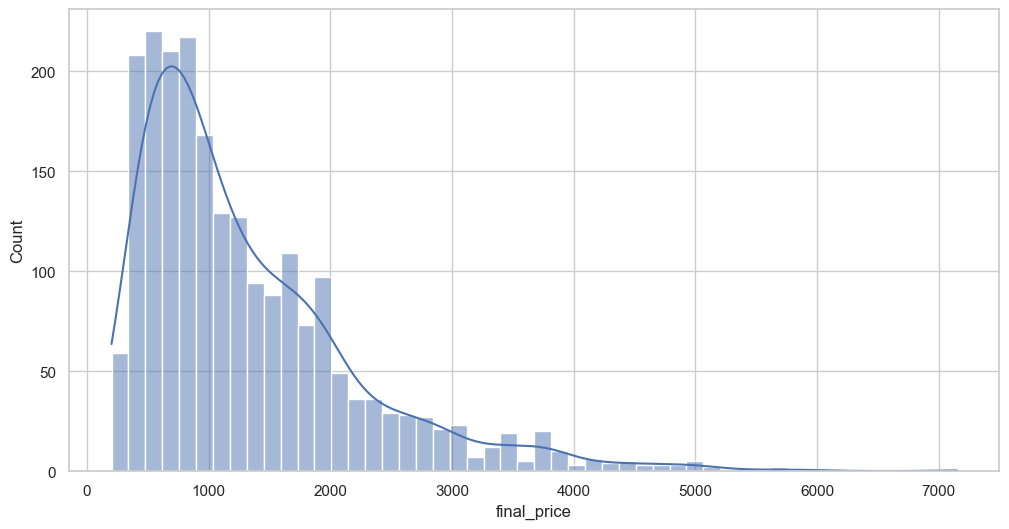

In [9]:
# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['final_price'], bins=50, kde=True)

<Axes: xlabel='final_price'>

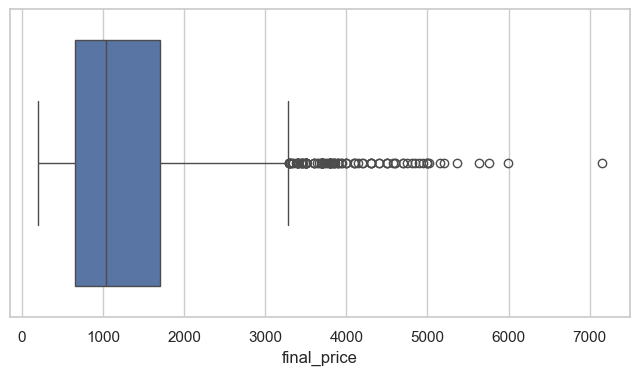

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['final_price'])

We can see that final_price column does indeed have a long tail according to the histogram and the boxplot

### Question 1 : There's one column with missing values. What is it?

In [11]:
df.isnull().sum()


ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2 What's the median (50% percentile) for variable 'ram'?

In [12]:
df['ram'].median()

16.0

#### Prepare and split the dataset

In [13]:
n = len(df)

n_val = int(n * 0.2)  # Number of validation samples
n_test = int(n * 0.2)  # Number of test samples
n_train = n - n_val - n_test  # Number of training samples

In [14]:
n , n_val, n_test, n_train 

(2160, 432, 432, 1296)

In [15]:
idx = np.arange(n) # Create an array of indices from 0 to n-1
np.random.seed(42) # Set the random seed to 42
np.random.shuffle(idx) # Shuffle the indices

In [16]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

### Question 3

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [18]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Prepare features and target variable
def prepare_X(df):
    X = df[['ram', 'storage', 'screen']].values
    return X

# Prepare target variable
def prepare_y(df):
    return df['final_price'].values

In [20]:
# Train and evaluate model
def train_and_evaluate(df_train, df_val, fill_value):
    # Fill missing values in 'screen' column
    df_train_filled = df_train.copy()
    df_val_filled = df_val.copy()

    df_train_filled['screen'] = df_train_filled['screen'].fillna(fill_value)
    df_val_filled['screen'] = df_val_filled['screen'].fillna(fill_value)

    # Prepare feature matrices
    X_train = prepare_X(df_train_filled)
    y_train = prepare_y(df_train_filled)
    X_val = prepare_X(df_val_filled)
    y_val = prepare_y(df_val_filled)

    # Train the model
    w_0, w = train_linear_regression(X_train, y_train)

    # Make predictions on validation set
    y_pred = w_0 + X_val.dot(w)

    # Compute RMSE on validation set
    return rmse(y_val, y_pred)

In [21]:
# Fill missing 'screen' values with 0
rmse_fill_0 = train_and_evaluate(df_train, df_val, 0)
print(f"RMSE with 'screen' filled with 0: {round(rmse_fill_0, 2)}")

RMSE with 'screen' filled with 0: 597.36


In [22]:
# Fill missing 'screen' values with mean from the training set
mean_screen = df_train['screen'].mean()
rmse_fill_mean = train_and_evaluate(df_train, df_val, mean_screen)
print(f"RMSE with 'screen' filled with mean: {round(rmse_fill_mean, 2)}")

RMSE with 'screen' filled with mean: 600.27


### Question 4

In [23]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg_matrix = r * np.eye(XTX.shape[0])  # Regularization term
    XTX = XTX + reg_matrix  # Adding regularization

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


In [24]:
# List of regularization values to try
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

In [25]:
def train_and_evaluate_reg(df_train, df_val, r):
    # Fill missing values in 'screen' column with 0
    df_train_filled = df_train.copy()
    df_val_filled = df_val.copy()

    df_train_filled['screen'] = df_train_filled['screen'].fillna(0)
    df_val_filled['screen'] = df_val_filled['screen'].fillna(0)

    # Prepare feature matrices
    X_train = prepare_X(df_train_filled)
    y_train = prepare_y(df_train_filled)
    X_val = prepare_X(df_val_filled)
    y_val = prepare_y(df_val_filled)

    # Train the model with regularization
    w_0, w = train_linear_regression_reg(X_train, y_train, r)

    # Make predictions on validation set
    y_pred = w_0 + X_val.dot(w)

    # Compute RMSE on validation set
    return rmse(y_val, y_pred)

In [26]:
# Fill missing 'screen' values with 0 and evaluate for each r
rmse_scores = []

for r in r_values:
    rmse_score = train_and_evaluate_reg(df_train, df_val,r)
    rmse_scores.append((r, round(rmse_score, 2)))

In [27]:
# Print the RMSE scores for each r value
for r, score in rmse_scores:
    print(f"RMSE for r={r}: {score}")

RMSE for r=0: 597.36
RMSE for r=0.01: 597.36
RMSE for r=0.1: 597.35
RMSE for r=1: 597.21
RMSE for r=5: 597.01
RMSE for r=10: 597.06
RMSE for r=100: 597.9


### Question 5

In [29]:
# Split the data into train/val/test sets based on a given seed
def split_data(df, seed):
    n = len(df)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    # Shuffle the dataset with the given seed
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    # Split into training, validation, and test sets
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    
    return df_train, df_val, df_test

In [30]:
# Train and evaluate model without regularization
def train_and_evaluate_seed(df_train, df_val):
    # Fill missing 'screen' values with 0
    df_train_filled = df_train.copy()
    df_val_filled = df_val.copy()

    df_train_filled['screen'] = df_train_filled['screen'].fillna(0)
    df_val_filled['screen'] = df_val_filled['screen'].fillna(0)

    # Prepare feature matrices
    X_train = prepare_X(df_train_filled)
    y_train = prepare_y(df_train_filled)
    X_val = prepare_X(df_val_filled)
    y_val = prepare_y(df_val_filled)

    # Train the model without regularization
    w_0, w = train_linear_regression(X_train, y_train)

    # Make predictions on validation set
    y_pred = w_0 + X_val.dot(w)

    # Compute RMSE on validation set
    return rmse(y_val, y_pred)

In [32]:
# List of seed values to try
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

# Loop over each seed value, split the data, and compute RMSE
for seed in seeds:
    df_train, df_val, df_test = split_data(df, seed)
    rmse_score = train_and_evaluate_seed(df_train, df_val)
    rmse_scores.append(rmse_score)

In [34]:
# Compute standard deviation of RMSE scores
rmse_std = np.std(rmse_scores)

# Print RMSE scores and standard deviation rounded to 3 decimal places
print("RMSE scores for each seed:", [round(score, 2) for score in rmse_scores])
print("Standard deviation of RMSE scores:", round(rmse_std, 3))

RMSE scores for each seed: [565.45, 636.8, 588.96, 597.81, 571.96, 573.24, 647.34, 550.44, 587.33, 576.1]
Standard deviation of RMSE scores: 29.176


### Question 6

In [36]:
# Split the data with seed 9
df_train, df_val, df_test = split_data(df, seed=9)

In [38]:
# Combine train and validation datasets
df_train_full = pd.concat([df_train, df_val]).reset_index(drop=True)
df_test_filled = df_test.copy()

# Fill missing values in 'screen' column with 0 for both train and test sets
df_train_full['screen'] = df_train_full['screen'].fillna(0)
df_test_filled['screen'] = df_test_filled['screen'].fillna(0)

In [39]:
# Prepare feature matrices for train and test sets
X_train_full = prepare_X(df_train_full)
y_train_full = prepare_y(df_train_full)
X_test = prepare_X(df_test_filled)
y_test = prepare_y(df_test_filled)

In [40]:
#Train the regularized linear regression model with r=0.001
w_0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)

#Make predictions on the test set
y_pred_test = w_0 + X_test.dot(w)

#Compute RMSE on the test set
rmse_test = rmse(y_test, y_pred_test)

In [41]:
print(f"RMSE on the test dataset: {round(rmse_test, 2)}")

RMSE on the test dataset: 608.61
